# CM4044 Mini Project 1

## Gathering and Loading Dataset

The FastF1 dataset can be accessed through the FastF1 Python library. It provides detailed information for each race event, including lap-by-lap performance data, car telemetry, weather conditions, session results, and driver profiles. From the telemetry data, users can access time-synchronized variables such as speed, throttle, brake, DRS activation, track position (X, Y), and more. From each session, we are able to get every lap data for all drivers.

### Objective

1. To predict lap time for 5 upcoming races by leveraging on lap-based analysis of 2023 and 2024 races, using regression models.
2. To suggest improvements for 2025 F1 drivers in terms of straight and cornering performance, using classification models

## Table of Contents
1. [Load and Prepare Formula 1 Race Sessions](#load-sessions)
2. [Data Pre-Processing](#data-preprocessing)
3. [Regression Models](#regression)
4. [Classification Models](#classification)

In [3]:
%pip install fastf1
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

%matplotlib inline
warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4

# Max speed for a data point to be classified as being part of a corner
SPEED_THRESHOLD = 200


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load and Prepare Formula 1 Race Sessions <a name="load-sessions"></a>

As we aim to predict lap time for upcoming 2025 races, we load 2023 and 2024 Grand Prix data from the FastF1 package to prepare a dataframe for regression analysis.

Upcoming races:
<ul>
  <li>Mexico City Grand Prix</li>
  <li>Brazilian Grand Prix</li>
  <li>Las Vegas Grand Prix</li>
  <li>Qatar Grand Prix</li>
  <li>Abu Dhabi Grand Prix</li>
</ul>

In [2]:
years = [2023, 2024, 2025]
sessions = {}
gp_events = ["Mexico City Grand Prix", "Brazilian Grand Prix", "Las Vegas Grand Prix", "Qatar Grand Prix", "Abu Dhabi Grand Prix"]

#Loading race session
def load_session(event, year):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return year, event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

for year in years:
    schedule = fastf1.get_event_schedule(year)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(load_session, e, year): e for e in gp_events}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                year, event, session = result
                sessions[(year, event)] = session

events      WARNING 	Correcting user input 'Brazilian Grand Prix' to 'São Paulo Grand Prix'
events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
core        WARNING 	Driver 1 completed the race distance 00:00.001000 before the recorded end of the session.
events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
events      WARNING 	Correcting user input 'Brazilian Grand Prix' to 'São Paulo Grand Prix'
core        WARNING 	No lap data for driver 23
core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Fixe

## Data Pre-processing <a name="data-preprocessing"></a>

### Compute Cornering and Telemetry Metrics for Each Race

For each Grand Prix event, we calculated the changes in X and Y positions to compute `Delta_Angle`, representing the change in the car's direction at each point.

In order to identify corners, we defined `CORNER_THRESHOLD` and the point at which the angle exceeds `CORNER_THRESHOLD`, the point will be defined as a corner. We processed the following telemetry data for all Grand Prix events into a single dataframe, `race_stats`, and saved to a CSV file for easy access.

In [ ]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[(2025, event)]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

### Visualize Telemetry Data and Cornering Events

Using data for each race event in `race_stats.csv`, we generated telemetry data visualization. The turns in each track is highlighted, along with a color scale to indicate the magnitude of directional changes.

In [ ]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"Race Track Viz/{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"Race Track Viz/{event}_isCorner.png")
    plt.close()

### Extract Driver Lap Statistics and Telemetry Metrics

In [ ]:
def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

import requests
import pandas as pd
from bs4 import BeautifulSoup

url = "https://formulapedia.com/how-long-are-f1-races/"
track_info = {}

response = requests.get(url)

soup = BeautifulSoup(response.content, "html.parser")

tbl = soup.find("tbody")
row = tbl.find_all('tr')

for r in row:
    raceName = r.find('td', class_="column-1")
    circuitLength = r.find('td', class_="column-3")
    raceDistance = r.find('td', class_="column-4")
    numLaps = r.find('td', class_="column-5")

    track_info[raceName.text] = {"circuitLength": circuitLength.text.split("km")[0], "raceDistance": raceDistance.text.split("km")[0], "numLaps": numLaps.text}

track_info['Mexico City Grand Prix'] = track_info.pop("Mexican Grand Prix")
track_info["Qatar Grand Prix"] = {"circuitLength": 5.419, "raceDistance": 308.883, "numLaps": 57}

### Dataframe Builder for Regression Model

Finally, we implemented the following master dataframe builder to use for regression analysis.

For each year and Grand Prix event, it iterates over all drivers and filters their laps to only include valid ones:
<ul>
  <li>Laps run under green flag conditions</li>
  <li>Excluding pit in/out laps</li>
  <li>First laps</li>
  <li>Complete timing data</li>
</ul>
For each valid lap, it extracts telemetry data (Speed, Throttle, Brake and DRS) and splits speeds into corner and straight segments by defining thresholds [Corner:(<200 km/h), Straight: (≥200 km/h)]. 

We also included information such as tyre compound and age, air and track temperatures, lap number and top speeds. All metrics are aggregated over a row per lap. Master dataframe is saved as `f1.csv` for easy access during regression analysis

In [ ]:
df = pd.DataFrame()
rows = []

years_train_test = [2023, 2024]

for year in years_train_test:
    for event in gp_events:
        session = sessions[(year, event)]
        weather = session.weather_data
        
        for num in session.drivers:
            driver = session.get_driver(num)['Abbreviation']
            team = session.get_driver(num)['TeamName']
            
            driver_laps_all = session.laps.pick_driver(driver)
            if driver_laps_all.empty:
                continue
            
            #TODO filter out wet weather laps
            #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
            valid_laps = driver_laps_all[(driver_laps_all['TrackStatus'] == '1') 
                                            & (driver_laps_all['PitInTime'].isna()) 
                                            & (driver_laps_all['PitOutTime'].isna()) 
                                            & (driver_laps_all['LapNumber'] > 1)].dropna(subset=['LapTime', 'Time']).reset_index(drop=True)
            if valid_laps.empty: continue
            
            valid_laps['Time_Minute'] = valid_laps['Time'].dt.round('min')
            
            for index, lap in valid_laps.iterrows():
                tel = lap.get_car_data()
                if tel is None:
                    continue

                weather_row = weather.iloc[(weather['Time'] - lap.Time).abs().argsort()[:1]]
                air_temp = weather_row['AirTemp'].values[0]
                track_temp = weather_row['TrackTemp'].values[0]
                
                corner_speeds = tel.query('Speed < 200')['Speed']
                straight_speeds = tel.query('Speed >= 200')['Speed']

                tyre_age = lap['TyreLife'] if 'TyreLife' in lap else lap['LapNumber'] - lap['StintStartLap']
                
                top_speed = 0
                top_speed_no_drs = 0
                if 'Speed' in tel:
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed:
                        top_speed = lap_top_speed
                else:
                    continue
                
                drs = tel['DRS'].values
                if 'Speed' in tel and drs.max() < 2: # looks for laps with no DRS enabled
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed_no_drs:
                        top_speed_no_drs = lap_top_speed
                else:
                    continue
                
                rows.append(
                    {
                        "Driver": driver,
                        "Team": team,
                        "Event": event,
                        "Year": year,
                        "LapTimeSeconds": lap['LapTime'].total_seconds(),
                        
                        "TyreCompound": lap['Compound'],
                        "TyreAge": tyre_age,
                        "AirTemp": air_temp,
                        "TrackTemp": track_temp,
                        
                        "TrackLength": track_info[event]["circuitLength"],
                        "RaceDistance": track_info[event]["raceDistance"],
                        "NumLaps": track_info[event]["numLaps"],
                        "LapNumber": lap['LapNumber'],

                        "TopSpeed": top_speed,
                        # "TopSpeedNoDelta": top_speed_no_drs,
                        "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                        "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                        "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                        "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                        "ThrottleMean": tel['Throttle'].mean(),
                        "ThrottleStdDev": tel['Throttle'].std(),
                        "BrakeMean": tel['Brake'].mean(),
                        "BrakeStdDev": tel['Brake'].std(),
                        "DRSMean": tel['DRS'].mean()
                    }
                )

df = pd.DataFrame(rows)

df.to_csv('f1.csv', index = False)

In [4]:
# Read "f1.csv"

%pip install patsy
%pip install statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Data Exploration

In [18]:
print(f"Dataframe Shape: {df.shape}\n")
print(f"Dataframe Size: {df.size}\n")
print(f"Dataframe Info: {df.info()}\n")

unique_drivers_per_team = df.groupby('Team')['Driver'].nunique()
print(f"Driver distribution by Team {unique_drivers_per_team}\n")
display(df.describe())



Dataframe Shape: (6400, 25)

Dataframe Size: 160000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Driver                 6400 non-null   object 
 1   Team                   6400 non-null   object 
 2   Event                  6400 non-null   object 
 3   Year                   6400 non-null   int64  
 4   LapTimeSeconds         6400 non-null   float64
 5   TyreCompound           6400 non-null   object 
 6   TyreAge                6400 non-null   float64
 7   AirTemp                6400 non-null   float64
 8   TrackTemp              6400 non-null   float64
 9   TrackLength            6400 non-null   float64
 10  RaceDistance           6400 non-null   float64
 11  NumLaps                6400 non-null   int64  
 12  LapNumber              6400 non-null   float64
 13  TopSpeed               6400 non-null   float64
 14  Avg

,Year,LapTimeSeconds,TyreAge,AirTemp,TrackTemp,TrackLength,RaceDistance,NumLaps,LapNumber,TopSpeed,...,AvgCornerEntrySpeed,AvgCornerExitSpeed,AvgStraightSpeed,AvgStraightEntrySpeed,AvgStraightExitSpeed,ThrottleMean,ThrottleStdDev,BrakeMean,BrakeStdDev,DRSMean
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,...,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,2023.517344,87.048072,16.125312,23.017063,31.584188,5.041742,306.159543,61.936094,34.460781,316.192813,...,160.086656,175.576156,264.565252,279.173187,266.952063,62.998856,41.676212,0.192688,0.392048,0.160884
std,0.499738,6.834553,9.312577,4.224880,9.241144,0.704194,1.267368,8.537470,17.749565,12.630912,...,12.364514,6.373403,10.021186,29.348034,38.350990,7.719838,1.657404,0.038561,0.029109,0.366725
min,2023.000000,72.486000,2.000000,17.000000,16.700000,4.304000,305.354000,50.000000,2.000000,252.000000,...,4.600000,99.800000,220.907407,208.000000,202.400000,30.820513,27.706134,0.099071,0.299221,0.000000
25%,2023.000000,82.982500,9.000000,19.875000,24.500000,4.309000,305.355000,55.000000,20.000000,306.000000,...,153.200000,172.000000,259.506584,260.000000,233.800000,55.864653,40.884099,0.162500,0.369477,0.000000
50%,2024.000000,86.373500,15.000000,21.100000,31.300000,5.419000,305.879000,57.000000,34.000000,311.000000,...,161.600000,176.200000,262.937497,283.800000,272.200000,64.932840,41.967191,0.186620,0.390294,0.000000
75%,2024.000000,90.057000,22.000000,26.500000,37.300000,5.554000,305.880000,71.000000,49.000000,328.000000,...,168.600000,180.000000,267.508632,306.200000,304.400000,69.000700,42.816189,0.222951,0.416910,0.000000
max,2024.000000,148.490000,50.000000,31.500000,50.200000,6.120000,308.883000,71.000000,71.000000,348.000000,...,196.400000,196.600000,291.352381,335.000000,332.800000,81.658147,45.164108,0.507937,0.500434,1.000000


In [81]:
%pip install numpy
%pip install --upgrade numba
from ydata_profiling import ProfileReport

df_eda = pd.read_csv('f1.csv')
profile = ProfileReport(df_eda, title="Profiling Report")
profile.to_file("f1_eda_report.html")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 365.93it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Assess Multicollinearity in Telemetry Features

In [5]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("LapTimeSeconds")

# Check VIF (Multicolinearity)
formula = f'Q("LapTimeSeconds") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable           VIF
0                    Intercept  5.199604e+07
1                    Q("Year")  2.846435e+00
2                 Q("TyreAge")  1.626086e+00
3                 Q("AirTemp")  5.426379e+00
4               Q("TrackTemp")  1.120810e+01
5             Q("TrackLength")  6.361936e+03
6            Q("RaceDistance")  1.955872e+01
7                 Q("NumLaps")  6.497449e+03
8               Q("LapNumber")  1.891349e+00
9                Q("TopSpeed")  1.498784e+01
10         Q("AvgCornerSpeed")  3.004907e+01
11    Q("AvgCornerEntrySpeed")  2.711299e+00
12     Q("AvgCornerExitSpeed")  1.106172e+00
13       Q("AvgStraightSpeed")  3.334770e+01
14  Q("AvgStraightEntrySpeed")  2.958356e+01
15   Q("AvgStraightExitSpeed")  2.498864e+01
16           Q("ThrottleMean")  1.181590e+01
17         Q("ThrottleStdDev")  2.109083e+00
18              Q("BrakeMean")  5.249995e+01
19            Q("BrakeStdDev")  5.585453e+01
20                Q("DRSMean")  4.108494e+00


In [6]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("TrackLength")

formula = f'Q("LapTimeSeconds") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable           VIF
0                    Intercept  4.594144e+07
1                    Q("Year")  2.663936e+00
2                 Q("TyreAge")  1.594434e+00
3                 Q("AirTemp")  4.772825e+00
4               Q("TrackTemp")  1.115781e+01
5            Q("RaceDistance")  1.716178e+01
6                 Q("NumLaps")  1.766146e+01
7               Q("LapNumber")  1.883181e+00
8                Q("TopSpeed")  1.449886e+01
9          Q("AvgCornerSpeed")  2.453592e+01
10    Q("AvgCornerEntrySpeed")  2.703183e+00
11     Q("AvgCornerExitSpeed")  1.098765e+00
12       Q("AvgStraightSpeed")  3.152579e+01
13  Q("AvgStraightEntrySpeed")  2.632192e+01
14   Q("AvgStraightExitSpeed")  2.334347e+01
15           Q("ThrottleMean")  1.111355e+01
16         Q("ThrottleStdDev")  2.048434e+00
17              Q("BrakeMean")  5.137803e+01
18            Q("BrakeStdDev")  5.449390e+01
19                Q("DRSMean")  3.770776e+00


## Build and Evaluate Machine Learning Models (Regression models) <a name="regression"></a>

For all regression models, the total 6401 data points will be split into train and test datasets in a 80:20 ratio using `train_test_split`. Model performance will be evaluated using R-squared values, whcih measures how well the features explain the variance in lap times, and RMSE (Root Mean Squared Error), which indicates the average prediction error in seconds.

In [7]:
x = df.drop(columns=['LapTimeSeconds'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df['LapTimeSeconds']

modelval_df = pd.DataFrame(columns=['Model', 'R-Squared', 'RMSE'])

### Linear Regression

To find the best regression model for analysis, we first use the linear regression model to predict lap times (y) using driver telemetry and race features (x). 

In [8]:
x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

y_pred_lm = model_lm.predict(x_test)

r2_lm = r2_score(y_test, y_pred_lm)
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_lm))


modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Linear Regression',
                                                     'R-Squared': r2_lm,
                                                     'RMSE': rmse_lm}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_lm}")
print(f"RMSE: {rmse_lm}")

modelval_df = modelval_df.drop_duplicates()

R-Squared: 0.9767282054360807
RMSE: 0.9943184113045596


### Random Forest Regressor

Next, we use the Random Forest Regression model to predict lap times (y) using driver telemetry and race features (x). Here, we utilized a randomized hyperparameter search (`RandomizedSearchCV`) to optimise the model by tuning `n_estimators` (Number of trees) and `min_samples_leaf` (Minimum samples required at a leaf node).

We also evaluated feature importance through a horizontal bar chart, providing insight into which aspects of the predictors are most significant for lap time optimization.

Best params: {'n_estimators': 37, 'min_samples_leaf': 1}
Test R-Squared: 0.9915449215131498
Test RMSE: 0.599334620779515


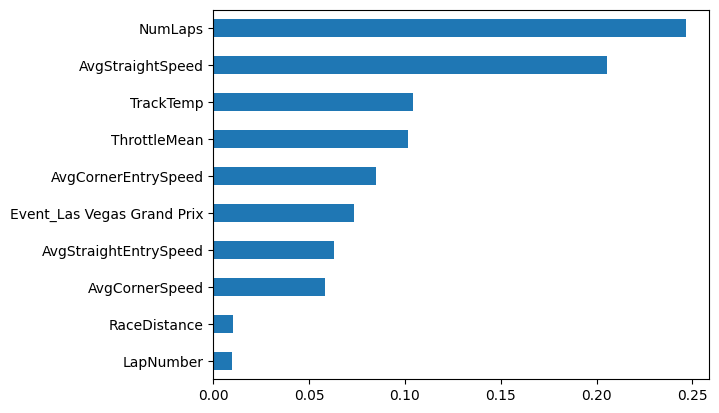

In [9]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(31, 41)),
              'min_samples_leaf': list(range(1, 2))
              }

rand_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    random_state=1
)

rand_search_rf.fit(x_train, y_train)

print("Best params:", rand_search_rf.best_params_)

best_rf = rand_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Random Forest Regression',
                                                     'R-Squared': r2_rf,
                                                     'RMSE': rmse_rf}])
                                                     ], ignore_index=True)

print(f"Test R-Squared: {r2_rf}")
print(f"Test RMSE: {rmse_rf}")

modelval_df = modelval_df.drop_duplicates()

importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
importances.sort_values().plot(kind='barh')
plt.show()

### XGBoost Regressor

Lastly, we use the XGBoost Regression model to predict lap times (y) using driver telemetry and race features (x). Here, we utilized a randomized hyperparameter search (`RandomizedSearchCV`) to optimise the model by tuning `n_estimators` (Number of boosting rounds) and `learning_rate` (Step size for each boosting iteration).

We also evaluated feature importance through a horizontal bar chart, providing insight into which aspects of the predictors are most significant for lap time optimization.

Compared to the previous models, XGBoost can capture non-linear relationships and interactions between features. Furthermore, it uses sequential boosting to iteratively reduce prediction errors. Overall, this model helps in handling complex patterns in large data at high accuracy.

In [10]:
%pip install xgboost

import xgboost as xgb

x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": list(range(650, 750)),
              "learning_rate": [0.03, 0.035, 0.04, 0.045, 0.05]
              }

rand_search_xgb = RandomizedSearchCV(
    estimator=xg,
    param_distributions=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    random_state=1
)

rand_search_xgb.fit(x_train, y_train)

print("Best params:", rand_search_xgb.best_params_)

best_xgb = rand_search_xgb.best_estimator_

y_pred = rand_search_xgb.predict(x_test)

r2_xg = r2_score(y_test, y_pred)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred))

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'XGBoost Regression',
                                                     'R-Squared': r2_xg,
                                                     'RMSE': rmse_xg}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_xg}")
print(f"RMSE: {rmse_xg}")

modelval_df = modelval_df.drop_duplicates()

importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
importances.sort_values().plot(kind='barh')
plt.show()


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <E8D72161-CCD1-3423-9388-36D4CA0A7524> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


,Model,R-Squared,RMSE
0,Linear Regression,0.976728,0.994318
1,Random Forest Regression,0.991545,0.599335


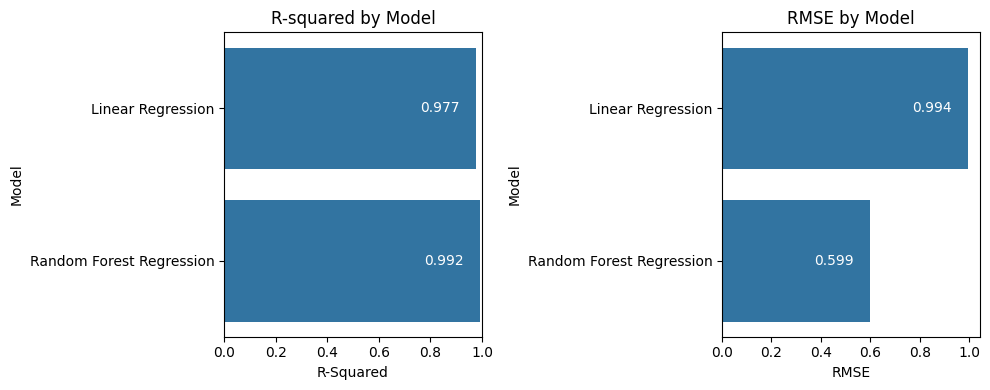

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

display(modelval_df)

sns.barplot(y='Model', x='R-Squared', data=modelval_df, ax=ax[0])
ax[0].set_title('R-squared by Model')
ax[0].set_xlim(0, 1)
for p in ax[0].patches:
    ax[0].annotate(
        format(p.get_width(), '.3f'),     
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),       
        textcoords='offset points'
    )

sns.barplot(y='Model', x='RMSE', data=modelval_df, ax=ax[1])
ax[1].set_title('RMSE by Model')
for p in ax[1].patches:
    ax[1].annotate(
        format(p.get_width(), '.3f'),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

### Quantifying the Irreducible Error

Theoretical minimum RMSE at R²=1: 0.37393926781791365
Theoretical RMSE at R²=0.999: 0.40059725252049816


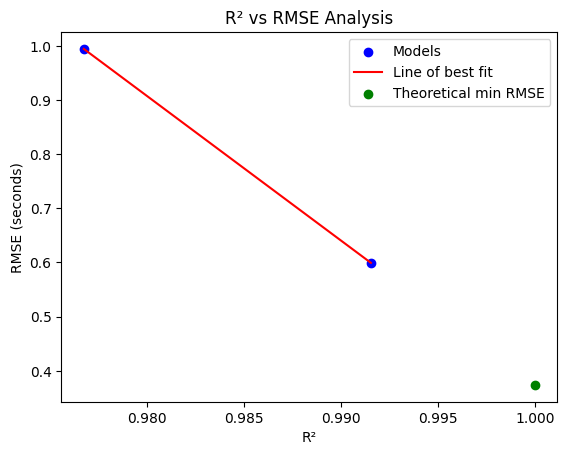

In [12]:
linreg = LinearRegression()
X = modelval_df["R-Squared"].values.reshape(-1, 1)
Y = modelval_df["RMSE"].values

linreg.fit(X, Y)

slope = linreg.coef_[0]
intercept = linreg.intercept_

rmse_r2_1 = linreg.predict(np.array([[1]]))[0]
rmse_r2_0999 = linreg.predict(np.array([[0.999]]))[0]

print("Theoretical minimum RMSE at R²=1:", rmse_r2_1)
print("Theoretical RMSE at R²=0.999:", rmse_r2_0999)

plt.scatter(modelval_df["R-Squared"], modelval_df["RMSE"], color='blue', label='Models')
plt.plot(X, linreg.predict(X), color='red', label='Line of best fit')
plt.scatter([1], [rmse_r2_1], color='green', label='Theoretical min RMSE')
plt.xlabel("R²")
plt.ylabel("RMSE (seconds)")
plt.title("R² vs RMSE Analysis")
plt.legend()
plt.show()

## Build and Evaluate Machine Learning Models (Classification models) <a name="classification"></a>

Next, we use classification models to suggest improvements for 2025 F1 drivers in terms of straight and cornering performance, using classification models. 

We were inclined to use 2025 Grand Prix races that occurred so far (as of 17 October 2025) as we feel that it is the most representative of the drivers' skill at corners and straights.

In [ ]:
years = [2025]
sessions = {}
gp_events = schedule[(schedule['EventName'].str.contains("Grand Prix")) & (schedule['EventDate'] <= datetime.datetime.now()) ]['EventName'].tolist()

#Loading race session for 2025 races
for year in years:
    schedule = fastf1.get_event_schedule(year)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(load_session, e, year): e for e in gp_events}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                year, event, session = result
                sessions[(year, event)] = session

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

url = "https://formulapedia.com/how-long-are-f1-races/"
track_info = {}

response = requests.get(url)

soup = BeautifulSoup(response.content, "html.parser")

tbl = soup.find("tbody")
row = tbl.find_all('tr')

for r in row:
    raceName = r.find('td', class_="column-1")
    circuitLength = r.find('td', class_="column-3")
    raceDistance = r.find('td', class_="column-4")
    numLaps = r.find('td', class_="column-5")

    track_info[raceName.text] = {"circuitLength": circuitLength.text.split("km")[0], "raceDistance": raceDistance.text.split("km")[0], "numLaps": numLaps.text}

track_info['Saudi Arabian Grand Prix'] = track_info.pop("Saudi Arabia Grand Prix")
track_info["Emilia Romagna Grand Prix"] = {"circuitLength": 4.909, "raceDistance": 309.05, "numLaps": 19}

In [ ]:
df_c = pd.DataFrame()
rows = []
gp_events = schedule[(schedule['EventName'].str.contains("Grand Prix")) & (schedule['EventDate'] <= datetime.datetime.now()) ]['EventName'].tolist()

for event in gp_events:
    session = fastf1.get_session(2025, event, 'R')
    session.load(telemetry=True, laps=True, weather=True)
    weather = session.weather_data
    
    for num in session.drivers:
            driver = session.get_driver(num)['Abbreviation']
            team = session.get_driver(num)['TeamName']
            
            driver_laps_all = session.laps.pick_driver(driver)
            if driver_laps_all.empty:
                continue
            
            #TODO filter out wet weather laps
            #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
            valid_laps = driver_laps_all[(driver_laps_all['TrackStatus'] == '1') 
                                            & (driver_laps_all['PitInTime'].isna()) 
                                            & (driver_laps_all['PitOutTime'].isna()) 
                                            & (driver_laps_all['LapNumber'] > 1)].dropna(subset=['LapTime', 'Time']).reset_index(drop=True)
            if valid_laps.empty: continue
            
            valid_laps['Time_Minute'] = valid_laps['Time'].dt.round('min')
            
            for index, lap in valid_laps.iterrows():
                tel = lap.get_car_data()
                if tel is None:
                    continue

                weather_row = weather.iloc[(weather['Time'] - lap.Time).abs().argsort()[:1]]
                air_temp = weather_row['AirTemp'].values[0]
                track_temp = weather_row['TrackTemp'].values[0]
                
                corner_speeds = tel.query('Speed < 200')['Speed']
                straight_speeds = tel.query('Speed >= 200')['Speed']

                tyre_age = lap['TyreLife'] if 'TyreLife' in lap else lap['LapNumber'] - lap['StintStartLap']
                
                top_speed = 0
                top_speed_no_drs = 0
                if 'Speed' in tel:
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed:
                        top_speed = lap_top_speed
                else:
                    continue
                
                drs = tel['DRS'].values
                if 'Speed' in tel and drs.max() < 2: # looks for laps with no DRS enabled
                    lap_top_speed = tel['Speed'].max()
                    if lap_top_speed > top_speed_no_drs:
                        top_speed_no_drs = lap_top_speed
                else:
                    continue
                
                rows.append(
                    {
                        "Driver": driver,
                        "Team": team,
                        "Event": event,
                        "Year": year,
                        "LapTimeSeconds": lap['LapTime'].total_seconds(),
                        
                        "TyreCompound": lap['Compound'],
                        "TyreAge": tyre_age,
                        "AirTemp": air_temp,
                        "TrackTemp": track_temp,
                        
                        "TrackLength": track_info[event]["circuitLength"],
                        "RaceDistance": track_info[event]["raceDistance"],
                        "NumLaps": track_info[event]["numLaps"],
                        "LapNumber": lap['LapNumber'],

                        "TopSpeed": top_speed,
                        # "TopSpeedNoDelta": top_speed_no_drs,
                        "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                        "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                        "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                        "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                        "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                        "ThrottleMean": tel['Throttle'].mean(),
                        "ThrottleStdDev": tel['Throttle'].std(),
                        "BrakeMean": tel['Brake'].mean(),
                        "BrakeStdDev": tel['Brake'].std(),
                        "DRSMean": tel['DRS'].mean()
                    }
                )

df_c = pd.DataFrame(rows)

df_c.to_csv('f1_classification.csv', index = False)

### Data Exploration

In [21]:
print(f"Dataframe Shape: {df_c.shape}\n")
print(f"Dataframe Size: {df_c.size}\n")
print(f"Dataframe Info: {df_c.info()}\n")

unique_drivers_per_team = df_c.groupby('Team')['Driver'].nunique()
print(f"Driver distribution by Team {unique_drivers_per_team}\n")
display(df_c.describe())

Dataframe Shape: (10864, 25)

Dataframe Size: 271600

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 0 to 11156
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Driver                 10864 non-null  object 
 1   Team                   10864 non-null  object 
 2   Event                  10864 non-null  object 
 3   Year                   10864 non-null  int64  
 4   LapTimeSeconds         10864 non-null  float64
 5   TyreCompound           10864 non-null  object 
 6   TyreAge                10864 non-null  float64
 7   AirTemp                10864 non-null  float64
 8   TrackTemp              10864 non-null  float64
 9   TrackLength            10864 non-null  float64
 10  RaceDistance           10864 non-null  float64
 11  NumLaps                10864 non-null  int64  
 12  LapNumber              10864 non-null  float64
 13  TopSpeed               10864 non-null  float64
 14  AvgCo

,Year,LapTimeSeconds,TyreAge,AirTemp,TrackTemp,TrackLength,RaceDistance,NumLaps,LapNumber,TopSpeed,...,AvgCornerEntrySpeed,AvgCornerExitSpeed,AvgStraightSpeed,AvgStraightEntrySpeed,AvgStraightExitSpeed,ThrottleMean,ThrottleStdDev,BrakeMean,BrakeStdDev,DRSMean
count,10864.0,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,...,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,2025.0,88.506042,16.800810,23.901298,34.805495,5.116727,304.255054,58.706001,33.192102,308.200479,...,155.722809,177.560512,259.006685,282.713641,269.099669,65.001856,41.763016,0.201035,0.397774,0.052627
std,0.0,11.330162,10.226258,4.902779,9.593287,0.854655,11.323295,12.993285,16.473613,13.181682,...,14.263630,8.651717,11.290536,20.332591,25.764444,6.889777,1.903911,0.043430,0.031658,0.221518
min,2025.0,68.085000,1.000000,14.200000,18.700000,3.337000,260.286000,19.000000,2.000000,217.000000,...,91.800000,121.000000,209.958333,206.200000,201.600000,30.080087,27.852160,0.099668,0.300055,0.000000
25%,2025.0,79.610000,9.000000,20.500000,27.100000,4.381000,306.198000,53.000000,20.000000,301.000000,...,146.400000,172.600000,251.514228,268.000000,251.000000,60.997292,40.651398,0.170418,0.376597,0.000000
50%,2025.0,90.411500,15.000000,24.100000,33.900000,5.063000,306.720000,57.000000,33.000000,309.000000,...,155.600000,177.600000,258.433084,284.600000,271.600000,65.112913,42.231922,0.199442,0.400175,0.000000
75%,2025.0,97.078000,23.000000,27.500000,42.900000,5.807000,308.238000,70.000000,46.000000,316.000000,...,164.800000,182.800000,264.921559,292.400000,281.600000,69.500644,43.183073,0.225627,0.418675,0.000000
max,2025.0,128.668000,71.000000,31.700000,50.400000,7.004000,309.050000,78.000000,78.000000,346.000000,...,197.400000,198.600000,287.183857,332.200000,335.600000,83.078947,46.093325,0.479412,0.500312,1.000000


In [20]:
# Read "f1_classification.csv" into dataframe for classification models
df_c = pd.read_csv("f1_classification.csv")
df_c.dropna(inplace=True)

In [56]:
x = df_c.drop(columns=['LapTimeSeconds'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df_c['LapTimeSeconds']

classifierval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score'])

In [57]:
labels = []
median_straight = df_c['AvgStraightSpeed'].median()
median_corner = df_c['AvgCornerSpeed'].median()

std_straight = df_c['AvgStraightSpeed'].std()
std_corner = df_c['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df_c.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### PCA

We appliced Principal Component Analysis (PCA) to our dataset to reduce its dimensionality. 

From our PCA plots, we observed that data clusters are more strongly separated by `Event` than by `Driver` or `Team`, indicating that lap performance, in terms of corners and straights competency, varies more significantly between race events. This insight suggests that evaluations of performance should be event-specific, rather than aggregated over the entire season, to capture the contextual differences for perfroamance.

Explained variance ratio (all PCs): [0.10832604 0.05849477 0.03995145 0.03781709 0.03391722 0.03306087
 0.03243694 0.03233408 0.03220228 0.03132724 0.02955743 0.0287265 ]
Total variance (all PCs): 0.4981519215426308
Variance explained by PC1 and PC2: 0.1668


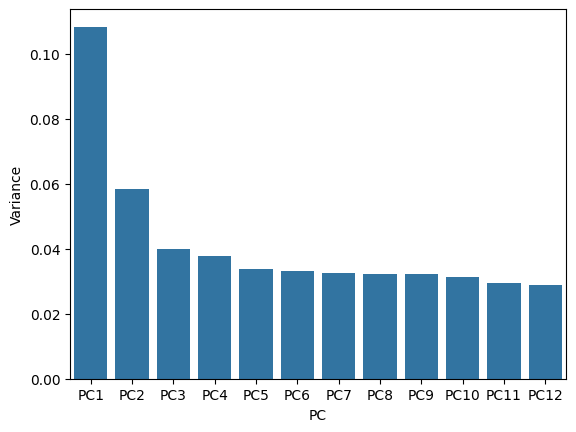

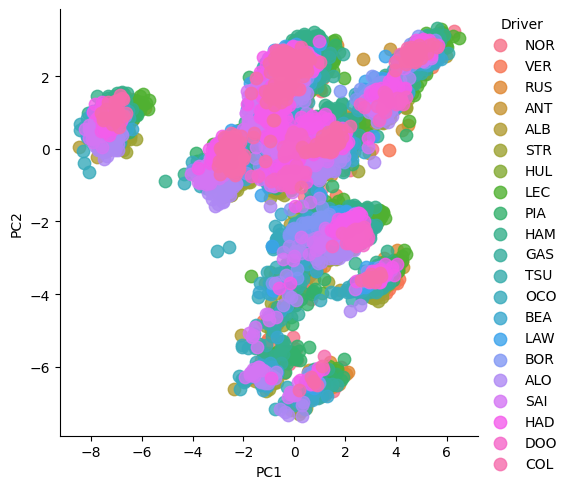

Explained variance ratio (all PCs): [0.10832604 0.05849477 0.03995145 0.03781709 0.03391722 0.03306087
 0.03243694 0.03233408 0.03220228 0.03132724 0.02955743 0.0287265 ]
Total variance (all PCs): 0.4981519215426308
Variance explained by PC1 and PC2: 0.1668


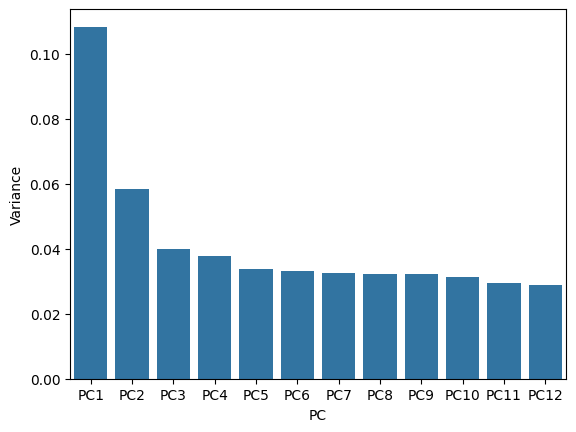

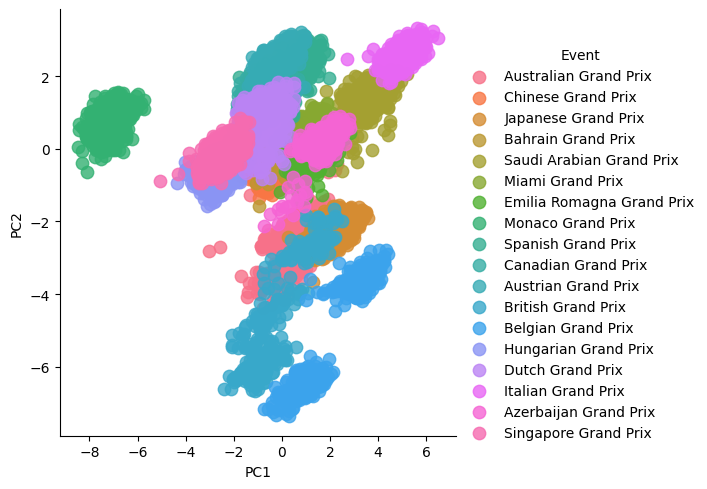

Explained variance ratio (all PCs): [0.10832604 0.05849477 0.03995145 0.03781709 0.03391722 0.03306087
 0.03243694 0.03233408 0.03220228 0.03132724 0.02955743 0.0287265 ]
Total variance (all PCs): 0.4981519215426308
Variance explained by PC1 and PC2: 0.1668


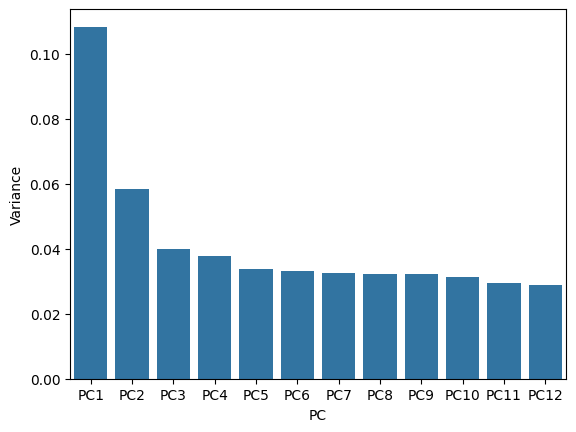

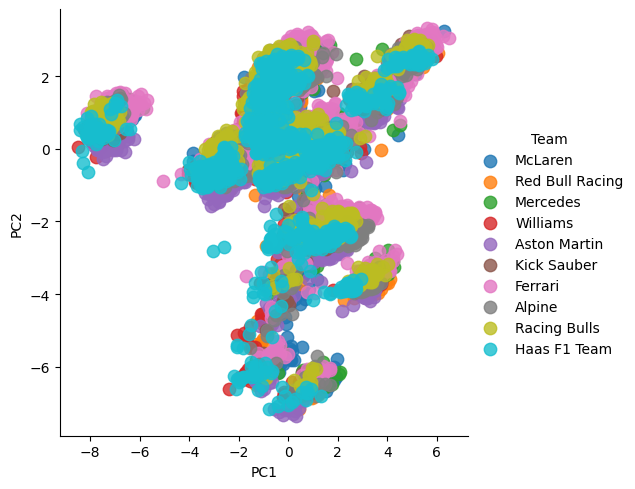

In [30]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
# features = ['TopSpeed','QualifyingTime','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
        #     'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

x = df_c.drop(columns=["LapTimeSeconds"]) # Separating out the features
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
x_scaled = StandardScaler().fit_transform(x) # Standardizing the features

def plot_pca(x, y, target,component_num=12, pc_x=1, pc_y=2):
        y = df_c[target] # Separating out the target
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(x)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df[target] = y.values
        #print(pc_df.head()) #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df)
        plt.show()
        plt.close()

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        sns.lmplot(x=pcx, y=pcy,
                data=pc_df, 
                fit_reg=False, 
                hue=target, # color by cluster
                legend=True,
                scatter_kws={"s": 80})
        plt.show() # specify the point size
        plt.close()

plot_pca(x_scaled, y, target='Driver',component_num=12, pc_x=1, pc_y=2)
plot_pca(x_scaled, y, target='Event',component_num=12, pc_x=1, pc_y=2)
plot_pca(x_scaled, y, target='Team',component_num=12, pc_x=1, pc_y=2) #change pc_x and pc_y value to change PC view

As a result of the significance of `Event` and therefore the nature of the track, we believe that it is important to perform classification by `Event`. 

Significant tracks that test different competencies:
<ul>
  <li>Straights performance
    <ul>
      <li>Azerbaijan Grand Prix</li>
      <li>Italian Grand Prix</li>
    </ul>
  </li>
  <li>Corners performance
    <ul>
      <li>Singapore Grand Prix</li>
      <li>Monaco Grand Prix</li>
    </ul>
  </li>
  <li>Performance at both straights and corners
    <ul>
      <li>British Grand Prix</li>
      <li>Belgium Grand Prix</li>
    </ul>
  </li>

In [58]:
dfc_filtered = df_c.loc[df_c['Event'] == 'Australian Grand Prix'] # Change event name

labels = []
median_straight = dfc_filtered['AvgStraightSpeed'].median()
median_corner = dfc_filtered['AvgCornerSpeed'].median()

std_straight = dfc_filtered['AvgStraightSpeed'].std()
std_corner = dfc_filtered['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in dfc_filtered.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### k-Nearest Neighbors

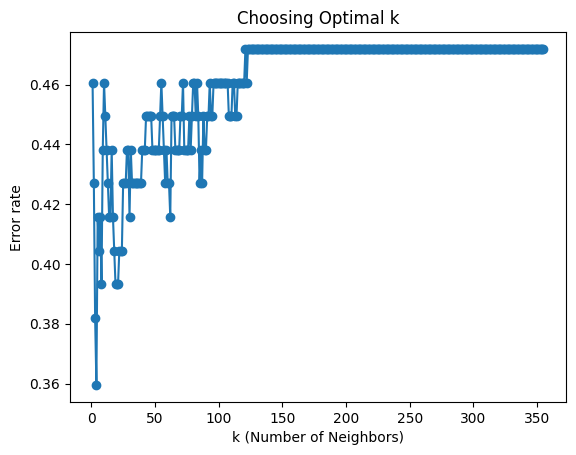

Accuracy: 0.6404494382022472
F1: 0.5964288520468295
                   precision    recall  f1-score   support

      Bad at both       0.65      0.89      0.75        47
     Good at both       0.67      0.67      0.67         9
  Good in corners       0.55      0.40      0.46        15
Good in straights       0.75      0.17      0.27        18

         accuracy                           0.64        89
        macro avg       0.65      0.53      0.54        89
     weighted avg       0.65      0.64      0.60        89

[[42  0  4  1]
 [ 3  6  0  0]
 [ 9  0  6  0]
 [11  3  1  3]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}


In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

df_knn = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for KNN
x = df_knn.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

# y-axis for kNN
le = LabelEncoder()
y = le.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size = 0.2, random_state = 1, stratify = y)

# Finding optimal k value
max_k = len(x_train)
k_values = range(1, max_k + 1)
error_rate = []

p = 1 #Manhatten distance better

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, p=p)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    error_rate.append(np.mean(predictions != y_test))

best_k = error_rate.index(min(error_rate)) + 1

plt.plot(k_values, error_rate, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error rate")
plt.title("Choosing Optimal k")
plt.show()

#Run proper kNN
knn = KNeighborsClassifier(n_neighbors = best_k, p=p)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

knn_accuracy = accuracy_score(y_test_labels, y_pred_labels)
knn_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", knn_accuracy)
print("F1:", knn_f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())

classifierval_df = pd.concat([classifierval_df, pd.DataFrame([{'Model': 'k-Nearest Neighbours',
                                                               'Accuracy': knn_accuracy,
                                                               'F1 Score': knn_f1}])
                                                              ], ignore_index=True)
classifierval_df = classifierval_df.drop_duplicates()


In [33]:
print("y train: ", np.unique(y_train, return_counts=True))
print("y test: ", np.unique(y_test, return_counts=True))

y train:  (array([0, 1, 2, 3]), array([187,  34,  60,  74]))
y test:  (array([0, 1, 2, 3]), array([47,  9, 15, 18]))


### Support Vector Machine

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df_svm = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for SVM
x = df_svm.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_reduced)

#y-axis for SVM
y = LabelEncoder().fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 1, stratify = y)

# Hyperparameter tuning
# param_grid = {
#     'C': [0.1, 1, 10, 100],          
#     'kernel': ['linear', 'rbf', 'poly'],  
#     'gamma': ['scale', 'auto', 0.1, 0.01]  
# }

# grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Accuracy:", grid.best_score_)

#SVM
svm = SVC(kernel='linear', C=6, gamma='scale')
svm.fit(x_train, y_train)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

svm_accuracy = accuracy_score(y_test_labels, y_pred_labels)
svm_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", svm_accuracy)
print("F1:", svm_f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(svm.get_params())

classifierval_df = pd.concat([classifierval_df, pd.DataFrame([{'Model': 'SVM',
                                                               'Accuracy': svm_accuracy,
                                                               'F1 Score': svm_f1}])
                                                              ], ignore_index=True)
classifierval_df = classifierval_df.drop_duplicates()

Accuracy: 0.9438202247191011
F1: 0.9439600269248694
                   precision    recall  f1-score   support

      Bad at both       0.98      0.96      0.97        47
     Good at both       0.82      1.00      0.90         9
  Good in corners       1.00      1.00      1.00        15
Good in straights       0.88      0.83      0.86        18

         accuracy                           0.94        89
        macro avg       0.92      0.95      0.93        89
     weighted avg       0.95      0.94      0.94        89

[[45  0  0  2]
 [ 0  9  0  0]
 [ 0  0 15  0]
 [ 1  2  0 15]]
{'C': 6, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### Naive Bayes Classifier

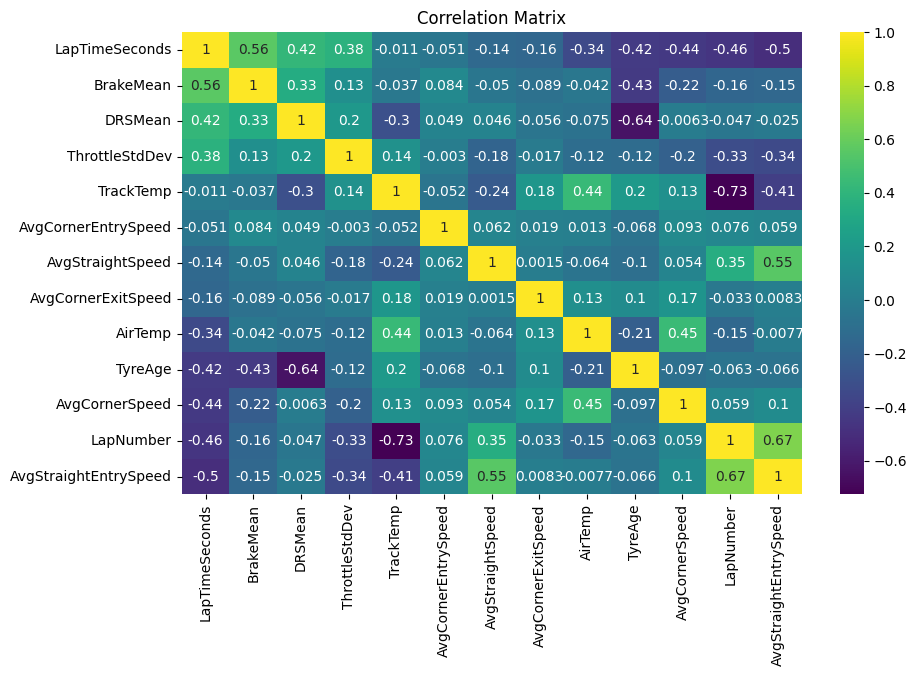

Accuracy: 0.7865168539325843
F1: 0.7719373391503158
                   precision    recall  f1-score   support

      Bad at both       0.78      0.98      0.87        47
     Good at both       0.75      0.67      0.71         9
  Good in corners       0.82      0.60      0.69        15
Good in straights       0.82      0.50      0.62        18

         accuracy                           0.79        89
        macro avg       0.79      0.69      0.72        89
     weighted avg       0.79      0.79      0.77        89

[[46  0  0  1]
 [ 0  6  2  1]
 [ 6  0  9  0]
 [ 7  2  0  9]]
{'priors': None, 'var_smoothing': 1e-09}


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# remove highly correlated columns
nb_df1 = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev",
                                    'Year','TrackLength', 'RaceDistance'])

x = nb_df1.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
y_encoded = LabelEncoder().fit_transform(labels)

# ---quality correlation matrix---
numeric_df = nb_df1.select_dtypes(include=np.number)
k = len(numeric_df.columns) - 1 # number of variables for heatmap
cols = numeric_df.corr().nlargest(k, 'LapTimeSeconds')['LapTimeSeconds'].index #change QT 
cm = numeric_df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()
plt.close()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

#hyperparameter tuning
# param_grid = {'var_smoothing': np.logspace(-12, -2, 20)}

# grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Accuracy:", grid.best_score_)

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

nb_accuracy = accuracy_score(y_test_labels, y_pred_labels)
nb_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", nb_accuracy)
print("F1:", nb_f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(nb.get_params())

classifierval_df = pd.concat([classifierval_df, pd.DataFrame([{'Model': 'Naive Bayes Classifier',
                                                               'Accuracy': nb_accuracy,
                                                               'F1 Score': nb_f1}])
                                                              ], ignore_index=True)
classifierval_df = classifierval_df.drop_duplicates()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

# param_grid = {
#     'C': np.logspace(-4, 4, 10),          
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],    
#     'max_iter': [500, 1000]
# }

# grid = GridSearchCV(
#     LogisticRegression(),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=1,
#     n_jobs=-1
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Accuracy:", grid.best_score_)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)  #evaluate the classifier by score 
acc = metrics.accuracy_score(y_test, y_pred)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

logreg_accuracy = accuracy_score(y_test_labels, y_pred_labels)
logreg_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", logreg_accuracy)
print("F1:", logreg_f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(log_reg.get_params())

classifierval_df = pd.concat([classifierval_df, pd.DataFrame([{'Model': 'Logistic Regression',
                                                               'Accuracy': logreg_accuracy,
                                                               'F1 Score': logreg_f1}])
                                                              ], ignore_index=True)
classifierval_df = classifierval_df.drop_duplicates()



Accuracy: 0.6404494382022472
F1: 0.6124950594275315
                   precision    recall  f1-score   support

      Bad at both       0.68      0.87      0.77        47
     Good at both       0.50      0.22      0.31         9
  Good in corners       0.57      0.53      0.55        15
Good in straights       0.55      0.33      0.41        18

         accuracy                           0.64        89
        macro avg       0.58      0.49      0.51        89
     weighted avg       0.62      0.64      0.61        89

[[41  0  2  4]
 [ 2  2  4  1]
 [ 5  2  8  0]
 [12  0  0  6]]
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


,Model,Accuracy,F1 Score
0,k-Nearest Neighbours,0.640449,0.596429
1,SVM,0.943820,0.943960
2,Naive Bayes Classifier,0.786517,0.771937
3,Logistic Regression,0.640449,0.612495


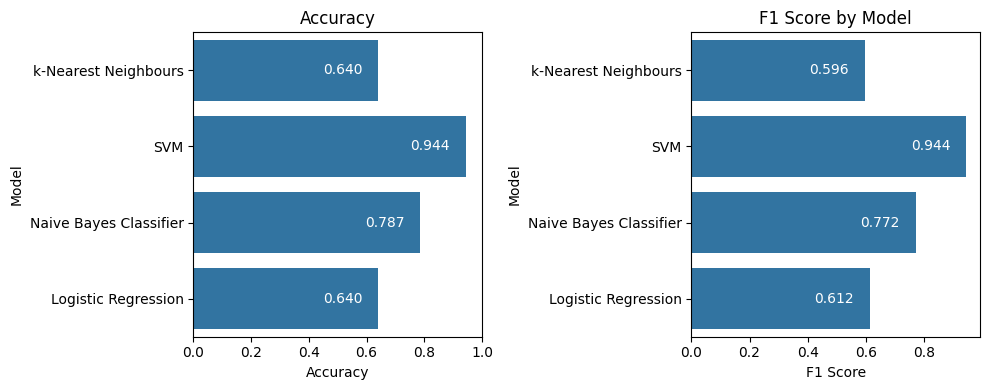

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

display(classifierval_df)

sns.barplot(y='Model', x='Accuracy', data=classifierval_df, ax=ax[0])
ax[0].set_title('Accuracy')
ax[0].set_xlim(0, 1)
for p in ax[0].patches:
    ax[0].annotate(
        format(p.get_width(), '.3f'),     
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),       
        textcoords='offset points'
    )

sns.barplot(y='Model', x='F1 Score', data=classifierval_df, ax=ax[1])
ax[1].set_title('F1 Score by Model')
for p in ax[1].patches:
    ax[1].annotate(
        format(p.get_width(), '.3f'),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

From the above bar plot, we can conclude that SVM is the best model, in terms of both **Accuracy** and **F1 Score**, at classifying driver performance at straights and corners. We will proceed to use the SVM model to classify drivers at specific Grand Prix races in order to identify strengths and weaknesses for performance improvement in the upcoming races.

In [131]:
labels = []
selected_races = ["Azerbaijan Grand Prix", "Italian Grand Prix", "Singapore Grand Prix", "Monaco Grand Prix","British Grand Prix", "Belgian Grand Prix"]
threshold = 0.2

svm_results_all = pd.DataFrame()

for event in selected_races:
    # Initialize
    dfc_filtered = df_c.loc[df_c['Event'] == event] # Change event name
    labels = []
    
    median_corner = dfc_filtered['AvgCornerSpeed'].median()
    std_corner = dfc_filtered['AvgCornerSpeed'].std()
    median_straight = dfc_filtered['AvgStraightSpeed'].median()
    std_straight = dfc_filtered['AvgStraightSpeed'].std()

    for _, row in dfc_filtered.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

    print(f"Performing SVM for {event}")
    df_svm = dfc_filtered.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])
    x = df_svm.drop(columns=['LapTimeSeconds', 'Driver', 'Team', 'Event', 'TyreCompound'])
    y = pd.Series(labels[:len(df_svm)], index=df_svm.index)  
    drivers = df_svm['Driver']
    x_scaled = StandardScaler().fit_transform(x)
    
    if len(y.unique()) < 2:
        print(f"Skipping {event}: only one class ({y.unique()[0]}) found.")
        continue

    x_train, x_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
        x_scaled, y, drivers, test_size=0.2, random_state=1, stratify=y
    )

    # Fit SVM
    svm = SVC(kernel='linear', C=6, gamma='scale')
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_test)

    # Map predictions back to driver names
    svm_classification_df = pd.DataFrame({
        'Driver': drivers_test.values,
        'Event': event,
        'PredictedCategory': y_pred,
        'TrueCategory': y_test.values
    
    })
    print(f"Completed SVM for {event}")
    svm_results_all = pd.concat([svm_results_all, svm_classification_df], ignore_index=True)

#svm_results_all = svm_results_all.drop_duplicates(subset=["Event", "Driver"], keep="first")
svm_results_all.to_csv("svm_classification_results.csv", index=False)
print(f"Category distribution by {svm_results_all.groupby('PredictedCategory').size()}\n")

def plot_perevent(df, event_name, folder="SVM_classification_plots"):
    all_drivers_order = svm_results_all['Driver'].unique()
    category_order = ["Bad at both", "Good in corners", "Good in straights", "Good at both"]
    
    if not os.path.exists(folder):
        os.makedirs(folder)

    df_event = df[df['Event'] == event_name].copy()
    df_event['PredictedCategory'] = pd.Categorical(df_event['PredictedCategory'],
                                                   categories=category_order,
                                                   ordered=True)
    plt.figure(figsize=(14, 8))
    order_drivers = df_event['Driver'].unique()
    category_order = svm_results_all['PredictedCategory'].value_counts().index
    sns.violinplot(data=df_event,x="Driver",y="PredictedCategory",order=all_drivers_order,hue=None,inner=None,linewidth=0,palette="Set3")
    sns.swarmplot(data=df_event, x="Driver", y="PredictedCategory",order=all_drivers_order, color="k", size=3, alpha=0.7)

    plt.title(f"Driver Classification by Predicted Category — {event_name}",
              fontsize=14, fontweight='bold')
    plt.xlabel("Driver", fontsize=12)
    plt.ylabel("Predicted Category", fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    save_path = os.path.join(folder, f"{event_name.replace(' ', '_')}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

for event in svm_results_all['Event'].unique():
    plot_perevent(svm_results_all, event, folder="SVM_classification_plots")


Performing SVM for Azerbaijan Grand Prix
Completed SVM for Azerbaijan Grand Prix
Performing SVM for Italian Grand Prix
Completed SVM for Italian Grand Prix
Performing SVM for Singapore Grand Prix
Completed SVM for Singapore Grand Prix
Performing SVM for Monaco Grand Prix
Completed SVM for Monaco Grand Prix
Performing SVM for British Grand Prix
Completed SVM for British Grand Prix
Performing SVM for Belgian Grand Prix
Completed SVM for Belgian Grand Prix
Category distribution by PredictedCategory
Bad at both          260
Good at both         113
Good in corners      153
Good in straights    160
dtype: int64

